In [6]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math

In [7]:
img_path = "C:\\Users\\tcuri\\Documents\\_UC Merced Documents\\research\\insite\\code\\unet\\CC7.265.1.2023.10.13.png"
mask_path = "C:\\Users\\tcuri\\Documents\\_UC Merced Documents\\research\\insite\\code\\unet\\CC7.265.1.2023.10.13_mask.png"
img = cv2.imread(img_path); img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = cv2.imread(filename=mask_path)

(1080, 1920, 3)


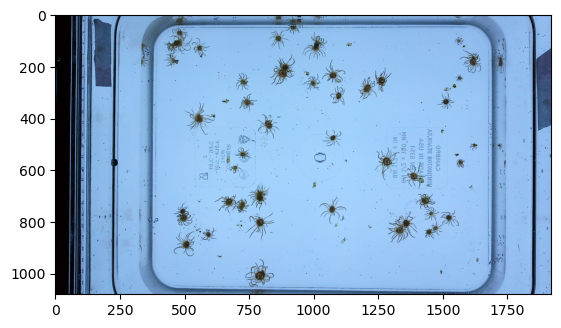

In [8]:
print(img.shape)
plt.imshow(img)
plt.show()

In [9]:
#function to obtain a list of tiles given an input image and size
def tileImage(img: np.ndarray, tile_size: int = 572) -> list[np.ndarray]:
    """
    Input: 
    - img: image of shape (height, width, channels)
    - tile_size: size of tiles

    Output:
    - List of tiles (images): 
    """
    tiles = [] #list of tiles

    #image is smaller than given tile size
    if img.shape[0] < tile_size or img.shape[1] < tile_size: 
        print("Image size is smaller than tile size")
        return False

    #getting number of tiles along height/width
    tiles_height = math.floor(img.shape[0] / tile_size)
    if (img.shape[0] % tile_size) != 0: tiles_height += 1 #incrementing if not divisble
    tiles_width = math.floor(img.shape[1] / tile_size)
    if (img.shape[1] % tile_size) != 0: tiles_width += 1 #incrementing if not divisble

    num_tiles = tiles_height * tiles_width #total number of tiles

    print(num_tiles, tiles_height, tiles_width)
    
    for h_tile in range(tiles_height):
        for w_tile in range(tiles_width):
            tile_top = h_tile*tile_size
            tile_bottom = (h_tile + 1)*tile_size
            tile_left = w_tile*tile_size
            tile_right = (w_tile + 1)*tile_size

            #check to avoid tile doesn't surpass image height
            if tile_bottom > img.shape[0]:
                tile_bottom = img.shape[0]
                tile_top = tile_bottom - tile_size
            
            #check to avoid tile doesn't surpass image width
            if tile_right > img.shape[1]: 
                tile_right = img.shape[1]
                tile_left = tile_right - tile_size
            
            tile = img[tile_top:tile_bottom, tile_left:tile_right, :]
            tiles.append(tile)
 
    return tiles

tile_size = 1000
tiles = tileImage(img=img, tile_size=tile_size)
len(tiles)

4 2 2


4

In [50]:
np.zeros((2, 2), dtype=img.dtype)

array([[0, 0],
       [0, 0]], dtype=uint8)

0 0 1000 0 1000
1 0 1000 1000 1920
2 1000 1080 0 1000
3 1000 1080 1000 1920


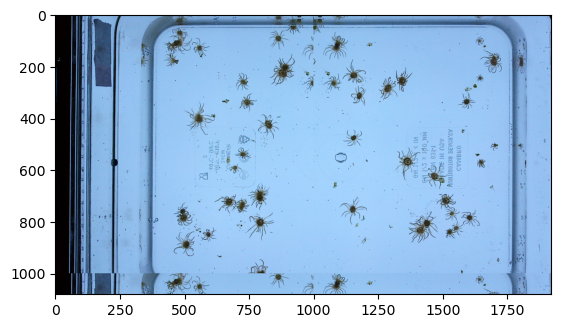

In [60]:
def stitchTiles(tiles: list[np.ndarray], img_shape: tuple[int]) -> np.ndarray:
    stiched_img = np.zeros(shape=img_shape, dtype=tiles[0].dtype) #initializing array of zeros as full size of image

    tile_size = tiles[0].shape[0] #size of tiles
    img_height = img_shape[0]; img_width = img_shape[1] #image height/width
    
    #getting number of tiles along height/width
    tiles_height = math.floor(img_height / tile_size)
    if (img_height % tile_size) != 0: tiles_height += 1 #incrementing if not divisble
    tiles_width = math.floor(img_width / tile_size)
    if (img_width % tile_size) != 0: tiles_width += 1 #incrementing if not divisble
    
    i = 0 #iterator

    for h_tile in range(tiles_height):
        for w_tile in range(tiles_width):
            tile_top = h_tile*tile_size
            tile_bottom = (h_tile + 1)*tile_size
            tile_left = w_tile*tile_size
            tile_right = (w_tile + 1)*tile_size

            #check to avoid tile doesn't surpass image height
            if tile_bottom > img.shape[0]:
                tile_bottom = img.shape[0]
                # tile_top = tile_bottom - tile_size
            
            #check to avoid tile doesn't surpass image width
            if tile_right > img.shape[1]: 
                tile_right = img.shape[1]
                # tile_left = tile_right - tile_size

            print(i, tile_top, tile_bottom, tile_left, tile_right)
            stiched_img[tile_top:tile_bottom, tile_left:tile_right, :] = tiles[i][:(tile_bottom - tile_top), :(tile_right - tile_left), :]
            i += 1
    
    return stiched_img

stiched_img = stitchTiles(tiles=tiles, img_shape=img.shape)
plt.imshow(stiched_img); plt.show()

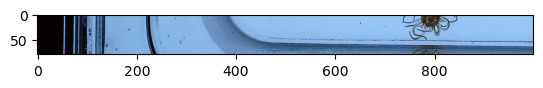

In [58]:
plt.imshow(tiles[2][(1000 - 80):, :, :])
plt.show()

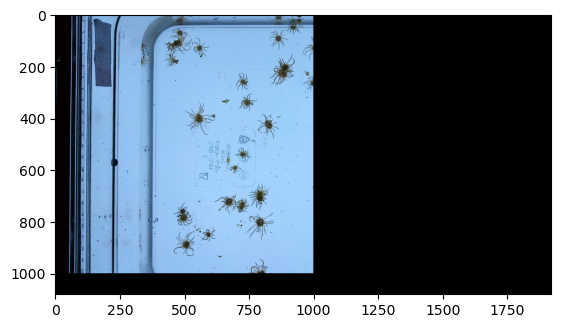

In [46]:
test = np.zeros(shape=img.shape, dtype='uint8')
test[:1000, :1000, :] = tiles[0]
plt.imshow(test)
plt.show()

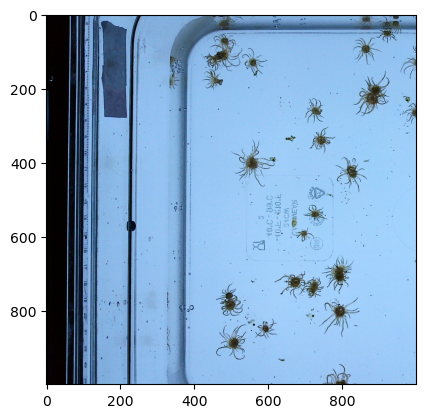

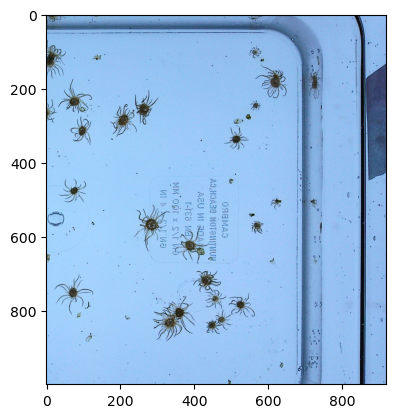

<Figure size 640x480 with 0 Axes>

In [10]:
# ###Do we disregard (i.e. not process) a tile if it does not contain aiptasia?
# plt.imshow(img[0:tile_size, 0:tile_size, :])
# plt.show()
# plt.clf()

# plt.imshow(img[0:tile_size, tile_size:2*tile_size, :])
# plt.show()
# plt.clf()

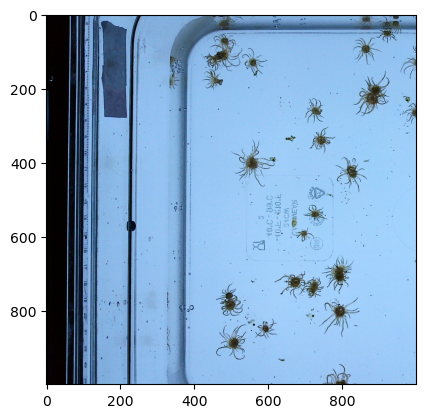

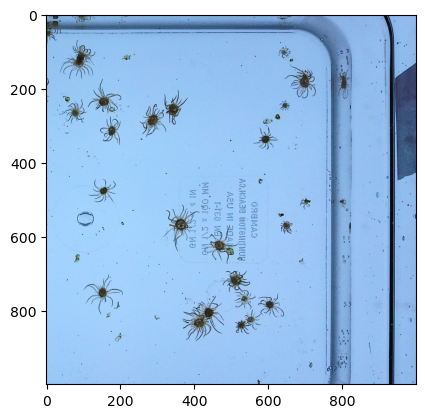

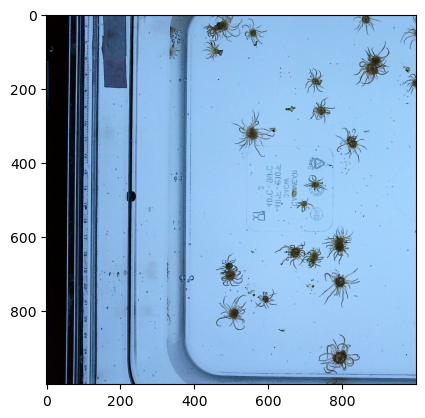

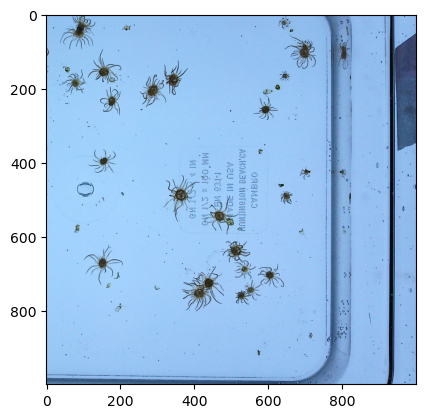

<Figure size 640x480 with 0 Axes>

In [11]:
for tile in tiles:
    plt.imshow(tile)
    plt.show()
    plt.clf()